In [1]:
pip install numpy pandas matplotlib


[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
data = pd.read_csv('./data/train.csv')

In [4]:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
data = np.array(data)
m, n = data.shape
np.random.shuffle(data)

data_dev = data[:1000].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n]
X_dev = X_dev / 255.

data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255.
_, m_train = X_train.shape

In [6]:
def ReLU(Z):
    # ReLU function
    # Return the maximum of 0 and Z
    # In other words:
    # If Z is positive, return Z
    # If Z is negative, return 0
    return np.maximum(0, Z)

def ReLU_deriv(Z):
    # Derivative of ReLU function
    # Return 1 if Z is positive, 0 otherwise
    return Z > 0

def softmax(Z):
    # Softmax function
    # Return the exponential of Z, divided by the sum of the exponential of Z
    return np.exp(Z) / sum(np.exp(Z))

def one_hot(Y):
    # One-hot encoding function
    # Return a matrix of 0s with the same shape of Y
    # Set the value of the index of Y to 1
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    # Return the transposed matrix to match the shape of the input
    return one_hot_Y.T    

In [7]:
def init_params():
    # Initialize the parameters
    W1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    
    W2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    
    W3 = np.random.rand(10, 10) - 0.5
    b3 = np.random.rand(10, 1) - 0.5
    
    return W1, b1, W2, b2, W3, b3

def forward_prop(W1, b1, W2, b2, W3, b3, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    
    Z2 = W2.dot(A1) + b2
    A2 = ReLU(Z2)
    
    Z3 = W3.dot(A2) + b3
    A3 = softmax(Z3)
    
    return Z1, A1, Z2, A2, Z3, A3
    
def back_prop(Z1, A1, Z2, A2, Z3, A3, W2, W3, X, Y):
    one_hot_Y = one_hot(Y)
    
    dZ3 = A3 - one_hot_Y
    dW3 = 1 / m * dZ3.dot(A2.T)
    db3 = 1 / m * np.sum(dZ3)
    
    dZ2 = W3.T.dot(dZ3) * ReLU_deriv(Z2)
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    
    return dW1, db1, dW2, db2, dW3, db3

def adam(params, grads, v, s, t, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
    for param, grad, v_param, s_param in zip(params, grads, v, s):
        v_param = beta1 * v_param + (1 - beta1) * grad
        s_param = beta2 * s_param + (1 - beta2) * (grad ** 2)
        v_corrected = v_param / (1 - beta1 ** t)
        s_corrected = s_param / (1 - beta2 ** t)
        param -= learning_rate * v_corrected / (np.sqrt(s_corrected) + epsilon)
    return params, v, s

In [8]:
def get_predictions(A3):
    # Get the index of the maximum value in A3
    return np.argmax(A3, 0)

def get_accuracy(predictions, Y):
    # Calculate the accuracy of the predictions
    print(predictions, Y)
    # Return the number of correct predictions
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, iters, learning_rate):
    W1, b1, W2, b2, W3, b3 = init_params()
    v = [np.zeros_like(W1), np.zeros_like(b1), np.zeros_like(W2), np.zeros_like(b2), np.zeros_like(W3), np.zeros_like(b3)]
    s = [np.zeros_like(W1), np.zeros_like(b1), np.zeros_like(W2), np.zeros_like(b2), np.zeros_like(W3), np.zeros_like(b3)]
    params = [W1, b1, W2, b2, W3, b3]
    
    for i in range(iters):
        Z1, A1, Z2, A2, Z3, A3 = forward_prop(W1, b1, W2, b2, W3, b3, X)
        dW1, db1, dW2, db2, dW3, db3 = back_prop(Z1, A1, Z2, A2, Z3, A3, W2, W3, X, Y)
        grads = [dW1, db1, dW2, db2, dW3, db3]
        
        params, v, s = adam(params, grads, v, s, i+1, learning_rate)
        W1, b1, W2, b2, W3, b3 = params
        
        if i % 10 == 0:
            print(f"Iteration {i}")
            predictions = get_predictions(A3)
            print(f"Accuracy: {get_accuracy(predictions, Y)}")
    
    return W1, b1, W2, b2, W3, b3

In [9]:
W1, b1, W2, b2, W3, b3 = gradient_descent(X_train, Y_train, 1000, 0.001)  # Note: typically use a lower learning rate with Adam

Iteration 0
[1 3 1 ... 3 1 1] [0 8 7 ... 5 2 6]
Accuracy: 0.09046341463414634
Iteration 10
[1 3 1 ... 3 1 1] [0 8 7 ... 5 2 6]
Accuracy: 0.10163414634146341
Iteration 20
[1 3 5 ... 1 1 1] [0 8 7 ... 5 2 6]
Accuracy: 0.11448780487804879
Iteration 30
[1 3 5 ... 1 1 1] [0 8 7 ... 5 2 6]
Accuracy: 0.136
Iteration 40
[1 3 5 ... 1 1 1] [0 8 7 ... 5 2 6]
Accuracy: 0.16726829268292684
Iteration 50
[1 3 5 ... 1 1 3] [0 8 7 ... 5 2 6]
Accuracy: 0.2064390243902439
Iteration 60
[1 3 5 ... 1 1 3] [0 8 7 ... 5 2 6]
Accuracy: 0.25034146341463415
Iteration 70
[1 5 7 ... 1 1 3] [0 8 7 ... 5 2 6]
Accuracy: 0.30148780487804877
Iteration 80
[1 5 7 ... 1 1 3] [0 8 7 ... 5 2 6]
Accuracy: 0.3533414634146341
Iteration 90
[1 8 7 ... 1 1 3] [0 8 7 ... 5 2 6]
Accuracy: 0.4063414634146341
Iteration 100
[1 8 7 ... 1 1 3] [0 8 7 ... 5 2 6]
Accuracy: 0.46002439024390246
Iteration 110
[1 8 7 ... 1 1 3] [0 8 7 ... 5 2 6]
Accuracy: 0.5126829268292683
Iteration 120
[1 8 7 ... 1 1 6] [0 8 7 ... 5 2 6]
Accuracy: 0.5642439

In [10]:
def make_predictions(X, W1, b1, W2, b2, W3, b3):
    _, _, _, _, _, A3 = forward_prop(W1, b1, W2, b2, W3, b3, X)
    predictions = get_predictions(A3)
    return predictions

def test_prediction(index, W1, b1, W2, b2, W3, b3):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2, W3, b3)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [0]
Label:  0


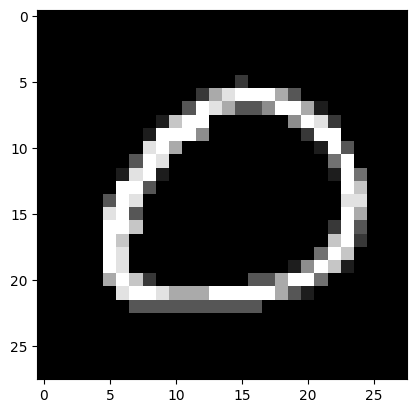

In [17]:
test_prediction(679, W1, b1, W2, b2, W3, b3)

In [18]:
dev_predictions = make_predictions(X_dev, W1, b1, W2, b2, W3, b3)
get_accuracy(dev_predictions, Y_dev)

[3 7 6 7 3 8 3 2 1 2 5 8 7 8 6 2 3 5 8 9 8 4 7 6 3 1 7 6 2 7 1 2 8 4 0 9 9
 7 9 2 1 4 8 1 9 2 2 5 1 8 2 1 5 4 1 8 7 3 1 4 6 4 4 0 1 5 3 9 2 2 9 0 1 5
 8 7 9 7 6 8 9 5 8 1 7 1 8 0 4 6 1 3 1 5 7 3 5 5 1 1 6 0 1 8 3 8 5 8 3 6 8
 5 9 0 7 2 7 5 8 3 3 2 0 8 1 1 1 0 3 1 2 7 8 8 1 5 0 9 3 2 8 8 9 3 7 7 8 2
 7 6 3 0 1 4 2 4 5 0 0 9 7 9 1 7 2 6 1 8 7 2 8 5 6 6 1 0 2 3 6 1 3 5 6 9 9
 1 4 9 0 1 5 5 7 0 5 7 7 1 1 5 0 2 6 6 7 4 1 5 6 5 0 8 4 7 1 5 6 6 5 3 9 3
 9 9 8 6 8 0 0 1 5 1 1 2 5 3 1 6 2 4 5 8 2 6 1 2 0 9 7 4 1 5 8 7 6 4 0 0 7
 0 5 8 1 3 9 4 5 6 6 0 4 7 7 3 2 0 1 8 8 9 6 1 2 6 7 3 3 1 6 3 9 8 9 6 4 5
 2 2 6 1 9 2 3 6 2 4 1 5 9 0 0 6 3 1 7 2 7 6 4 4 5 4 5 4 7 5 5 1 6 6 5 5 1
 6 8 2 4 6 5 8 9 8 6 1 0 4 1 1 2 4 1 5 7 2 9 1 8 3 8 6 2 2 1 4 5 2 5 7 1 9
 4 9 0 4 6 8 6 6 5 1 7 6 2 5 5 5 1 5 3 4 1 1 4 6 1 7 6 1 3 5 3 6 2 7 2 5 2
 5 7 7 3 0 9 5 0 2 3 3 1 8 3 2 1 3 8 9 0 0 7 3 4 4 8 8 4 1 1 9 3 0 8 1 4 4
 3 2 6 3 7 9 7 3 1 0 5 3 5 1 4 9 3 7 8 1 7 5 7 1 8 7 7 5 0 7 5 5 9 6 2 3 7
 8 6 6 8 1 4 5 3 1 3 5 2 

0.886